Codigo anterior:


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import plotly.graph_objects as go
from math import sqrt, pi, exp
import itertools

# Auxiliares

def gaussian_norm(alpha, l=0):
    """Normalización aproximada para gaussianas primitivas"""
    if l == 0:
        return (2 * alpha / pi) ** 0.75
    elif l == 1:
        return (128 * alpha**5 / pi**3)**0.25
    else:
        return 1.0

def boys_F0(t):
    """Función de Boys F0"""
    if t < 1e-12:
        return 1.0
    return 0.5 * sqrt(pi / t) * erf(sqrt(t))

def product_center(alpha, A, beta, B):
    p = alpha + beta
    P = (alpha * A + beta * B) / p
    return P, p

# Integrales

def overlap_ss(a, A, b, B):
    R2 = np.dot(A - B, A - B)
    return (pi / (a + b))**1.5 * exp(-a * b / (a + b) * R2)

def kinetic_ss(a, A, b, B):
    R2 = np.dot(A - B, A - B)
    p = a + b
    pre = a * b / p
    return pre * (3 - 2 * pre * R2) * (pi / p)**1.5 * exp(-pre * R2)

def nuclear_attraction_ss(a, A, b, B, C, Z=1.0):
    P, p = product_center(a, A, b, B)
    R2 = np.dot(P - C, P - C)
    K = exp(-a * b / (a + b) * np.dot(A - B, A - B))
    return -Z * 2 * pi / p * K * boys_F0(p * R2)

def eri_ssss(a, A, b, B, c, C, d, D):
    P, p = product_center(a, A, b, B)
    Q, q = product_center(c, C, d, D)
    Kab = exp(-a * b / p * np.dot(A - B, A - B))
    Kcd = exp(-c * d / q * np.dot(C - D, C - D))
    RPQ2 = np.dot(P - Q, P - Q)
    return (2 * pi**2.5) / (p * q * sqrt(p + q)) * Kab * Kcd * boys_F0(p * q / (p + q) * RPQ2)

# Bases gausianas

class BasisFunction:
    def __init__(self, center, primitives, type='s'):
        self.center = np.array(center, dtype=float)
        self.primitives = primitives
        self.type = type

    def evaluate_point(self, r):
        """Evalúa (no vectorizada) en un punto r; útil para cortes 2D."""
        val = 0.0
        R2 = np.sum((r - self.center)**2)
        if self.type == 's':
            for a, c in self.primitives:
                val += c * exp(-a * R2)
        else:
            # simplificación
            dz = r[2] - self.center[2]
            for a, c in self.primitives:
                val += c * dz * exp(-a * R2)
        return val

def STO3G_1s(center):
    alphas = np.array([3.42525091, 0.62391373, 0.16885540])
    coeffs = np.array([0.15432897, 0.53532814, 0.44463454])
    prims = []
    for a, c in zip(alphas, coeffs):
        N = gaussian_norm(a, l=0)
        prims.append((a, c * N))
    return BasisFunction(center, prims, type='s')

# Construir matrices STV

def build_matrices(basis, centers, Zlist):
    n = len(basis)
    S = np.zeros((n, n))
    T = np.zeros((n, n))
    V = np.zeros((n, n))
    G = np.zeros((n, n, n, n))

    # 1-electrón
    for mu in range(n):
        for nu in range(mu + 1):
            valS = 0.0
            valT = 0.0
            valV = 0.0
            A = basis[mu].center
            B = basis[nu].center
            for (a, ca) in basis[mu].primitives:
                for (b, cb) in basis[nu].primitives:
                    valS += ca * cb * overlap_ss(a, A, b, B)
                    valT += ca * cb * kinetic_ss(a, A, b, B)
                    for C, Z in zip(centers, Zlist):
                        valV += ca * cb * nuclear_attraction_ss(a, A, b, B, C, Z)
            S[mu, nu] = S[nu, mu] = valS
            T[mu, nu] = T[nu, mu] = valT
            V[mu, nu] = V[nu, mu] = valV

    # 2-electrones ERI
    for mu in range(n):
        A = basis[mu].center
        for nu in range(n):
            B = basis[nu].center
            for lam in range(n):
                Cc = basis[lam].center
                for sig in range(n):
                    D = basis[sig].center
                    val = 0.0
                    for (a, ca) in basis[mu].primitives:
                        for (b, cb) in basis[nu].primitives:
                            for (c, cc) in basis[lam].primitives:
                                for (d, cd) in basis[sig].primitives:
                                    val += ca * cb * cc * cd * eri_ssss(a, A, b, B, c, Cc, d, D)
                    G[mu, nu, lam, sig] = val

    return S, T, V, G

# Hf solver

class HartreeFockSolver:
    def __init__(self, S, Hcore, G, n_electrons, E_nuc=0.0):
        self.S = S
        self.H = Hcore
        self.G = G
        self.n_electrons = n_electrons
        self.E_nuc = E_nuc

        # X = S^{-1/2}
        eigvals, eigvecs = np.linalg.eigh(S)
        eigvals[eigvals < 1e-12] = 1e-12
        self.X = eigvecs @ np.diag(eigvals**-0.5) @ eigvecs.T

        self.n_orb = S.shape[0]
        self.n_occ = n_electrons // 2
        self.has_single = (n_electrons % 2 == 1)

    def build_fock(self, P):
        n = self.n_orb
        F = self.H.copy()
        for p in range(n):
            for q in range(n):
                contrib = 0.0
                for r in range(n):
                    for s in range(n):
                        contrib += P[r, s] * (self.G[p, q, r, s] - 0.5 * self.G[p, s, r, q])
                F[p, q] += contrib
        return F

    def make_density(self, C):
        P = np.zeros((self.n_orb, self.n_orb))
        # Doblemente ocupados
        for i in range(self.n_occ):
            ci = C[:, i]
            P += 2.0 * np.outer(ci, ci)
        # Electrón impar
        if self.has_single and self.n_occ < self.n_orb:
            ci = C[:, self.n_occ]
            P += 1.0 * np.outer(ci, ci)
        return P

    def run_scf(self, conv=1e-8, max_iter=100, verbose=True):
        # guess inicial
        F0 = self.X.T @ self.H @ self.X
        eps0, C0 = np.linalg.eigh(F0)
        C = self.X @ C0
        P = self.make_density(C)

        E_old = 0.0
        energies = [] # guardar las energías para ver convergencia después
        for it in range(max_iter):
            F = self.build_fock(P)
            Ft = self.X.T @ F @ self.X
            eps, C2 = np.linalg.eigh(Ft)
            C = self.X @ C2
            P_new = self.make_density(C)

            E_elec = 0.5 * np.sum(P * (self.H + F))
            E_total = E_elec + self.E_nuc
            energies.append(E_total)

            dP = np.linalg.norm(P_new - P)
            dE = E_total - E_old

            if verbose:
                print(f"Iter {it+1:3d}: E = {E_total:.10f}  dE = {dE:.2e}  dP = {dP:.2e}")

            if abs(dE) < conv and dP < conv:
                if verbose:
                    print(f"Convergencia alcanzada en {it+1} iteraciones")
                break

            P = P_new
            E_old = E_total

        return E_total, eps, C, P, energies



Visualización

Anillo de hidrógeno H6
--------------------------------------------------

GEOMETRÍA: RING
Número de átomos: 6
Distancia característica: 2.0 bohr

Coordenadas de los átomos (bohr):
  Átomo 1: (2.000, 0.000, 0.000)
  Átomo 2: (1.000, 1.732, 0.000)
  Átomo 3: (-1.000, 1.732, 0.000)
  Átomo 4: (-2.000, 0.000, 0.000)
  Átomo 5: (-1.000, -1.732, 0.000)
  Átomo 6: (1.000, -1.732, 0.000)

Energía nuclear de repulsión: 5.482051 Hartree

Construyendo matrices (S, T, V, G)...
Iter   1: E = -3.1407167391  dE = -3.14e+00  dP = 1.08e-14
Iter   2: E = -3.1407167391  dE = -1.78e-15  dP = 3.81e-15
Convergencia alcanzada en 2 iteraciones

RESULTADOS:
  Energía total = -3.1407167391 Hartree
  Energía por átomo = -0.523453 Hartree
  Energías orbitales:
    MO 1: -0.705304 Hartree (ocupado)
    MO 2: -0.407027 Hartree (ocupado)
    MO 3: -0.407027 Hartree (ocupado)
    MO 4: 0.425097 Hartree 
    MO 5: 0.425097 Hartree 
    MO 6: 0.927953 Hartree 


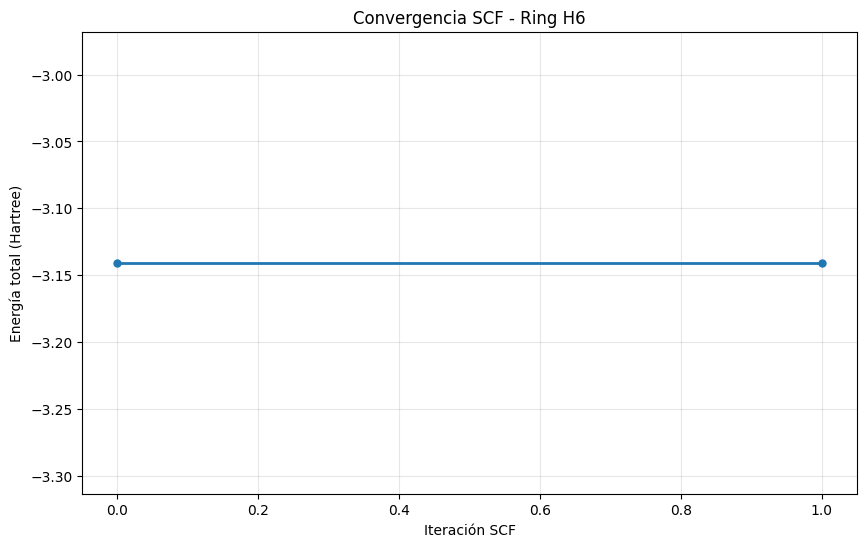



 Tetraedro de hidrógeno H4
--------------------------------------------------

GEOMETRÍA: TETRAHEDRON
Número de átomos: 4
Distancia característica: 1.5 bohr

Coordenadas de los átomos (bohr):
  Átomo 1: (0.866, 0.866, 0.866)
  Átomo 2: (0.866, -0.866, -0.866)
  Átomo 3: (-0.866, 0.866, -0.866)
  Átomo 4: (-0.866, -0.866, 0.866)

Energía nuclear de repulsión: 2.449490 Hartree

Construyendo matrices (S, T, V, G)...
Iter   1: E = -1.4462369431  dE = -1.45e+00  dP = 3.45e-01
Iter   2: E = -1.4809703947  dE = -3.47e-02  dP = 7.80e-02
Iter   3: E = -1.4819923345  dE = -1.02e-03  dP = 2.16e-02
Iter   4: E = -1.4820389577  dE = -4.66e-05  dP = 3.08e-02
Iter   5: E = -1.4820949126  dE = -5.60e-05  dP = 5.88e-02
Iter   6: E = -1.4822969399  dE = -2.02e-04  dP = 1.12e-01
Iter   7: E = -1.4830320518  dE = -7.35e-04  dP = 2.11e-01
Iter   8: E = -1.4856175559  dE = -2.59e-03  dP = 3.74e-01
Iter   9: E = -1.4937209349  dE = -8.10e-03  dP = 5.66e-01
Iter  10: E = -1.5121078458  dE = -1.84e-02  dP = 

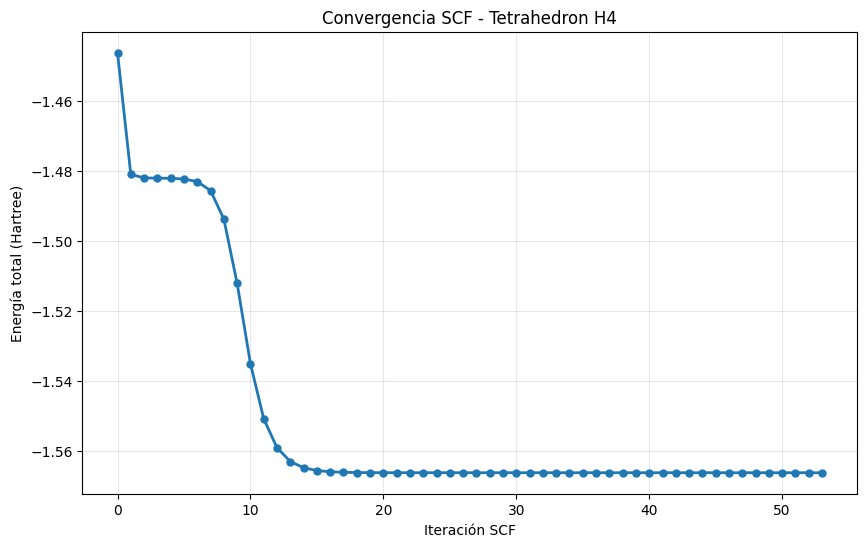



 Cadena lineal de hidrógeno H5
--------------------------------------------------

GEOMETRÍA: CHAIN
Número de átomos: 5
Distancia característica: 1.5 bohr

Coordenadas de los átomos (bohr):
  Átomo 1: (-3.000, 0.000, 0.000)
  Átomo 2: (-1.500, 0.000, 0.000)
  Átomo 3: (0.000, 0.000, 0.000)
  Átomo 4: (1.500, 0.000, 0.000)
  Átomo 5: (3.000, 0.000, 0.000)

Energía nuclear de repulsión: 4.277778 Hartree

Construyendo matrices (S, T, V, G)...
Iter   1: E = -2.1332851568  dE = -2.13e+00  dP = 1.66e+00
Iter   2: E = -2.4304775248  dE = -2.97e-01  dP = 1.99e-01
Iter   3: E = -2.4358595772  dE = -5.38e-03  dP = 3.03e-02
Iter   4: E = -2.4359833723  dE = -1.24e-04  dP = 4.36e-03
Iter   5: E = -2.4359873857  dE = -4.01e-06  dP = 9.73e-04
Iter   6: E = -2.4359875541  dE = -1.68e-07  dP = 1.81e-04
Iter   7: E = -2.4359875620  dE = -7.97e-09  dP = 4.29e-05
Iter   8: E = -2.4359875624  dE = -3.95e-10  dP = 9.04e-06
Iter   9: E = -2.4359875624  dE = -1.99e-11  dP = 2.08e-06
Iter  10: E = -2.435987

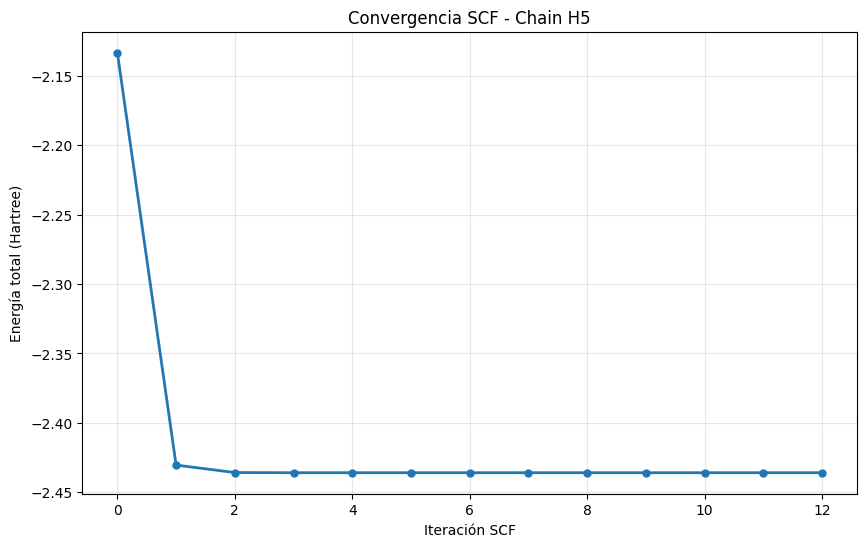


COMPARACIÓN FINAL DE ENERGÍAS
Anillo H6:     -3.140717 Hartree  (-0.523453 por átomo)
Tetraedro H4:  -1.566154 Hartree  (-0.391539 por átomo)
Cadena H5:     -2.435988 Hartree  (-0.487198 por átomo)


In [40]:
# Visualizador

class MolecularVisualizer:
    def __init__(self, basis, centers, Zlist, C=None):
        self.basis = basis
        self.centers = centers
        self.Zlist = Zlist
        self.C = C

    def plot_density_3d(self, P, grid_points=28, grid_range=5.0, title='Densidad electrónica 3D'):
        """Grafica densidad electrónica usando Volume de Plotly"""
        x = np.linspace(-grid_range, grid_range, grid_points)
        y = np.linspace(-grid_range, grid_range, grid_points)
        z = np.linspace(-grid_range, grid_range, grid_points)
        X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
        coords = np.stack([X, Y, Z], axis=-1)
        shape = X.shape

        n = len(self.basis)
        bf_vals = np.zeros((n, ) + shape)
        for mu, bf in enumerate(self.basis):
            diff = coords - bf.center
            R2 = np.sum(diff**2, axis=-1)
            val = np.zeros_like(R2)
            if bf.type == 's':
                for a, c in bf.primitives:
                    val += c * np.exp(-a * R2)
            else:
                dz = diff[..., 2]
                for a, c in bf.primitives:
                    val += c * dz * np.exp(-a * R2)
            bf_vals[mu] = val

        # rho = sum_{mu,nu} P_{mu,nu} phi_mu phi_nu
        rho = np.zeros(shape)
        for mu in range(n):
            for nu in range(n):
                rho += P[mu, nu] * bf_vals[mu] * bf_vals[nu]

        # Escalar para visualización
        flat = rho.flatten()
        vmax = flat.max() if flat.size > 0 else 1.0
        isomin = max(1e-6, 0.03 * vmax)
        isomax = max(isomin * 2.0, 0.35 * vmax)

        fig = go.Figure(data=go.Volume(
            x=X.flatten(),
            y=Y.flatten(),
            z=Z.flatten(),
            value=rho.flatten(),
            isomin=isomin,
            isomax=isomax,
            opacity=0.15,
            surface_count=20,
            colorscale='Plasma',
            showscale=True
        ))

        # núcleos con colores diferentes
        colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']
        for i, (center, Z) in enumerate(zip(self.centers, self.Zlist)):
            color_idx = i % len(colors)
            fig.add_trace(go.Scatter3d(
                x=[center[0]],
                y=[center[1]],
                z=[center[2]],
                mode='markers+text',
                marker=dict(size=12, color=colors[color_idx], opacity=0.9),
                text=[f'H{i+1}'],
                textposition="top center",
                name=f'Átomo {i+1}'
            ))

        fig.update_layout(
            title=title,
            scene=dict(
                xaxis_title='X (bohr)',
                yaxis_title='Y (bohr)',
                zaxis_title='Z (bohr)',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                )
            ),
            width=1000,
            height=800,
            showlegend=True
        )
        return fig

# Geometrías

def create_h4_square(R=1.5):
    """H4 en configuración cuadrada (cuadrado plano)"""
    centers = [
        np.array([-R/2, -R/2, 0.0]),
        np.array([ R/2, -R/2, 0.0]),
        np.array([ R/2,  R/2, 0.0]),
        np.array([-R/2,  R/2, 0.0])
    ]
    Zlist = [1, 1, 1, 1]
    basis = [STO3G_1s(c) for c in centers]
    return centers, Zlist, basis, 4  # 4 electrones

def create_h4_tetrahedron(R=1.5):
    """H4 en configuración tetraédrica"""
    # Coordenadas de un tetraedro regular
    centers = [
        np.array([1.0, 1.0, 1.0]),
        np.array([1.0, -1.0, -1.0]),
        np.array([-1.0, 1.0, -1.0]),
        np.array([-1.0, -1.0, 1.0])
    ]
    # Escalar
    centers = [R/np.sqrt(3) * c for c in centers]
    Zlist = [1, 1, 1, 1]
    basis = [STO3G_1s(c) for c in centers]
    return centers, Zlist, basis, 4

def create_h5_pyramid(R=1.5):
    """H5 en configuración piramidal (base cuadrada + vértice)"""
    centers = [
        # Base cuadrada
        np.array([-R, -R, 0.0]),
        np.array([ R, -R, 0.0]),
        np.array([ R,  R, 0.0]),
        np.array([-R,  R, 0.0]),
        # Vértice superior
        np.array([0.0, 0.0, R])
    ]
    Zlist = [1, 1, 1, 1, 1]
    basis = [STO3G_1s(c) for c in centers]
    return centers, Zlist, basis, 5

def create_h6_octahedron(R=1.5):
    """H6 en configuración octaédrica"""
    centers = [
        np.array([ R, 0.0, 0.0]),
        np.array([-R, 0.0, 0.0]),
        np.array([0.0,  R, 0.0]),
        np.array([0.0, -R, 0.0]),
        np.array([0.0, 0.0,  R]),
        np.array([0.0, 0.0, -R])
    ]
    Zlist = [1, 1, 1, 1, 1, 1]
    basis = [STO3G_1s(c) for c in centers]
    return centers, Zlist, basis, 6

def create_h_chain(n_atoms=5, R=1.5):
    """Cadena lineal de átomos de hidrógeno"""
    centers = []
    for i in range(n_atoms):
        x = (i - (n_atoms-1)/2) * R
        centers.append(np.array([x, 0.0, 0.0]))

    Zlist = [1] * n_atoms
    basis = [STO3G_1s(c) for c in centers]
    return centers, Zlist, basis, n_atoms

def create_h_ring(n_atoms=6, R=2.0):
    """Anillo de átomos de hidrógeno"""
    centers = []
    for i in range(n_atoms):
        angle = 2 * np.pi * i / n_atoms
        x = R * np.cos(angle)
        y = R * np.sin(angle)
        centers.append(np.array([x, y, 0.0]))

    Zlist = [1] * n_atoms
    basis = [STO3G_1s(c) for c in centers]
    return centers, Zlist, basis, n_atoms


def run_geometry_example(geometry_type='square', R=1.5, neutral=True, grid_points=28):
    """
    Ejecuta HF para diferentes geometrías de hidrógeno
    geometry_type: 'square', 'tetrahedron', 'pyramid', 'octahedron', 'chain', 'ring'
    """

    # Seleccionar geometría
    if geometry_type == 'square':
        centers, Zlist, basis, n_atoms = create_h4_square(R)
    elif geometry_type == 'tetrahedron':
        centers, Zlist, basis, n_atoms = create_h4_tetrahedron(R)
    elif geometry_type == 'pyramid':
        centers, Zlist, basis, n_atoms = create_h5_pyramid(R)
    elif geometry_type == 'octahedron':
        centers, Zlist, basis, n_atoms = create_h6_octahedron(R)
    elif geometry_type == 'chain':
        centers, Zlist, basis, n_atoms = create_h_chain(5, R)
    elif geometry_type == 'ring':
        centers, Zlist, basis, n_atoms = create_h_ring(6, R)
    else:
        raise ValueError(f"Geometría no reconocida: {geometry_type}")

    print(f"\n{'='*60}")
    print(f"GEOMETRÍA: {geometry_type.upper()}")
    print(f"Número de átomos: {n_atoms}")
    print(f"Distancia característica: {R} bohr")


    # Imprimir coordenadas
    print("\nCoordenadas de los átomos (bohr):")
    for i, c in enumerate(centers):
        print(f"  Átomo {i+1}: ({c[0]:.3f}, {c[1]:.3f}, {c[2]:.3f})")

    # Calcular energía nuclear de repulsión
    E_nuc = 0.0
    for i in range(len(centers)):
        for j in range(i+1, len(centers)):
            R_ij = np.linalg.norm(centers[i] - centers[j])
            E_nuc += Zlist[i] * Zlist[j] / R_ij
    print(f"\nEnergía nuclear de repulsión: {E_nuc:.6f} Hartree")

    # Construir matrices
    print("\nConstruyendo matrices (S, T, V, G)...")
    S, T, V, G = build_matrices(basis, centers, Zlist)
    Hcore = T + V

    n_electrons = n_atoms

    solver = HartreeFockSolver(S, Hcore, G, n_electrons, E_nuc=E_nuc)

    E_tot, eps, C, P, energies = solver.run_scf(conv=1e-8, max_iter=100, verbose=True)

    print(f"\n{'='*60}")
    print("RESULTADOS:")
    print(f"  Energía total = {E_tot:.10f} Hartree")
    print(f"  Energía por átomo = {E_tot/n_atoms:.6f} Hartree")
    print(f"  Energías orbitales:")
    for i, e in enumerate(eps):
        print(f"    MO {i+1}: {e:.6f} Hartree {'(ocupado)' if i < n_electrons//2 else ''}")

    # Visualización 3D
    vis = MolecularVisualizer(basis, centers, Zlist, C=C)
    title = f'Densidad electrónica - {geometry_type.capitalize()} H{n_atoms}'
    if not neutral:
        title += '⁺'

    fig = vis.plot_density_3d(P, grid_points=grid_points,
                              grid_range=max(R*2, 4.0), title=title)
    fig.show()

    # Gráfico de convergencia
    plt.figure(figsize=(10, 6))
    plt.plot(energies, 'o-', linewidth=2, markersize=5)
    plt.xlabel('Iteración SCF')
    plt.ylabel('Energía total (Hartree)')
    plt.title(f'Convergencia SCF - {geometry_type.capitalize()} H{n_atoms}')
    plt.grid(True, alpha=0.3)
    plt.show()

    return E_tot, eps, C, P, centers


# Run principal de visualizaciones

if __name__ == "__main__":
    # Anillo de 6 hidrógenos
    print("Anillo de hidrógeno H6")
    print("-" * 50)
    E_tot1, eps1, C1, P1, centers1 = run_geometry_example(
        geometry_type='ring',
        R=2.0,  # Radio del anillo
        neutral=True,
        grid_points=28
    )

    # Tetraedro H4
    print("\n\n Tetraedro de hidrógeno H4")
    print("-" * 50)
    E_tot2, eps2, C2, P2, centers2 = run_geometry_example(
        geometry_type='tetrahedron',
        R=1.5,
        neutral=True,
        grid_points=26
    )

    # Cadena lineal de 5 hidrógenos
    print("\n\n Cadena lineal de hidrógeno H5")
    print("-" * 50)
    E_tot3, eps3, C3, P3, centers3 = run_geometry_example(
        geometry_type='chain',
        R=1.5,
        neutral=True,
        grid_points=30
    )

    # Comparación final
    print(f"\n{'='*60}")
    print("COMPARACIÓN FINAL DE ENERGÍAS")
    print(f"{'='*60}")
    print(f"Anillo H6:     {E_tot1:.6f} Hartree  ({E_tot1/6:.6f} por átomo)")
    print(f"Tetraedro H4:  {E_tot2:.6f} Hartree  ({E_tot2/4:.6f} por átomo)")
    print(f"Cadena H5:     {E_tot3:.6f} Hartree  ({E_tot3/5:.6f} por átomo)")
